In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StochasticSamplingConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, height, width, device='cuda'):
        super(StochasticSamplingConv2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.height = height
        self.width = width

        # Random initialization for Gaussian sampling parameters
        # mu_x and mu_y should be between 0 and height/width
        self.mu_x = nn.Parameter(torch.randint(0, height, (in_channels, height, width), dtype=torch.float32)).to(device)  # mu_x between 0 and height-1
        self.mu_y = nn.Parameter(torch.randint(0, width, (in_channels, height, width), dtype=torch.float32)).to(device)  # mu_y between 0 and width-1

        # Random standard deviation values for sigma_x and sigma_y
        self.sigma_x = nn.Parameter(torch.rand(in_channels, height, width) * 2).to(device)  # Adjust range as needed
        self.sigma_y = nn.Parameter(torch.rand(in_channels, height, width) * 2).to(device)  # Adjust range as needed

        # Kernel offset for sampling around each pixel
        k_offset = torch.tensor([
            [i, j]
            for i in range(-kernel_size // 2 + 1, kernel_size // 2 + 1)
            for j in range(-kernel_size // 2 + 1, kernel_size // 2 + 1)
        ]).reshape(kernel_size, kernel_size, 2)
        self.k_offset = k_offset.to(device)

        # Convolution weights (out_channels x in_channels x kernel_size x kernel_size)
        self.weights = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size)).to(device)

    def forward(self, x):
        batch_size, in_c, height, width = x.shape

        # Expanding mu and sigma to apply sampling over kernel space
        mu_x_exp = self.mu_x.unsqueeze(-1).unsqueeze(-1) + self.k_offset[:, :, 0]
        mu_y_exp = self.mu_y.unsqueeze(-1).unsqueeze(-1) + self.k_offset[:, :, 1]
        sigma_x_exp = self.sigma_x.unsqueeze(-1).unsqueeze(-1)
        sigma_y_exp = self.sigma_y.unsqueeze(-1).unsqueeze(-1)

        # Sampling kernel values
        x_kernel = torch.randn_like(mu_x_exp) * sigma_x_exp + mu_x_exp
        y_kernel = torch.randn_like(mu_y_exp) * sigma_y_exp + mu_y_exp

        # Clamping to ensure indices are within valid range
        x_kernel = torch.clamp(x_kernel, min=0, max=self.height - 1)
        y_kernel = torch.clamp(y_kernel, min=0, max=self.width - 1)

        # Create batch indices for advanced indexing
        batch_indices = torch.arange(batch_size).reshape(batch_size, 1, 1, 1, 1, 1).expand(batch_size, in_c, height, width, self.kernel_size, self.kernel_size)
        channel_indices = torch.arange(in_c).reshape(1, in_c, 1, 1, 1, 1).expand(batch_size, in_c, height, width, self.kernel_size, self.kernel_size)

        # Expanding kernel values to match batch size and input size
        x_kernel_expanded = x_kernel.unsqueeze(0).expand(batch_size, in_c, height, width, self.kernel_size, self.kernel_size)
        y_kernel_expanded = y_kernel.unsqueeze(0).expand(batch_size, in_c, height, width, self.kernel_size, self.kernel_size)

        # Converting kernel indices to long type for indexing
        x_kernel_expanded = x_kernel_expanded.long().to(x.device)
        y_kernel_expanded = y_kernel_expanded.long().to(x.device)

        # Advanced indexing to sample the input image using the kernel indices
        sampled_tensor = x[batch_indices, channel_indices, x_kernel_expanded, y_kernel_expanded].permute(0, 2, 3, 1, 4, 5)

        # Reshape and apply 2D convolution
        sampled_tensor = sampled_tensor.reshape(-1, self.in_channels, self.kernel_size, self.kernel_size)
        output = F.conv2d(sampled_tensor, self.weights.to(x.device))

        # Reshaping output to original batch size and channel dimensions
        output = output.view(batch_size, height, width, self.out_channels).permute(0, 3, 1, 2)
        
        return output


In [9]:
# Define a small CNN model with SSC Layer
class SSCNet(nn.Module):
    def __init__(self, input_shape):
        super(SSCNet, self).__init__()
        self.ssc1 = StochasticSamplingConv2D(1, 16, kernel_size=3, height=input_shape[0], width=input_shape[1])
        self.conv1 = nn.Conv2d(16, 16, 3, padding=1)
        self.ssc2 = StochasticSamplingConv2D(16, 32, kernel_size=3, height=input_shape[0] // 2, width=input_shape[1] // 2)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.fc = nn.Linear(32 * (input_shape[0] // 4) * (input_shape[1] // 4), 10)

    def forward(self, x):
        x = self.ssc1(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.ssc2(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [10]:
# Load MNIST dataset
def load_mnist(batch_size=64, val_split=0.1):
    transform = transforms.Compose([transforms.ToTensor()])
    
    # Load the MNIST dataset
    full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Calculate the size of the validation set
    val_size = int(len(full_train_dataset) * val_split)
    train_size = len(full_train_dataset) - val_size
    
    # Split the training set into train and validation sets
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
    
    # Create DataLoaders for training, validation, and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [14]:
# Train the model
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=5):
    model.train()
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total_samples = 0

        for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc='Training', total=len(train_loader)):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total_samples += target.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total_samples
        train_loss.append(avg_loss)
        train_accuracy.append(accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

        # Validation step after each epoch
        val_loss_epoch, val_accuracy_epoch, _ = evaluate_model(model, val_loader, criterion, device)
        val_loss.append(val_loss_epoch)
        val_accuracy.append(val_accuracy_epoch)
        print(f"Validation Loss: {val_loss_epoch:.4f}, Validation Accuracy: {val_accuracy_epoch * 100:.2f}%")

    return train_loss, train_accuracy, val_loss, val_accuracy


# Evaluate the model
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in tqdm(data_loader, desc='Evaluating', total=len(data_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = criterion(output, target)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total_samples += target.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total_samples

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, cm


# Plotting the learning curve and confusion matrix
def plot_learning_curve(train_loss, train_accuracy, val_loss, val_accuracy):
    # Plot Loss Curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label="Training Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [32]:
def main(device):
    train_loader, val_loader, test_loader = load_mnist()
    model = SSCNet((28, 28)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print("Training the model...")
    train_loss, train_accuracy, val_loss, val_accuracy = train_model(
        model, train_loader, val_loader, optimizer, criterion, device, epochs=20
    )

    print("Evaluating the model...")
    _, _, cm = evaluate_model(model, test_loader, criterion, device)

    # Plot the learning curve
    plot_learning_curve(train_loss, train_accuracy, val_loss, val_accuracy)

    # Plot confusion matrix
    labels = [str(i) for i in range(10)]  # MNIST digits
    plot_confusion_matrix(cm, labels)
    return model

Training the model...


Training: 100%|██████████| 844/844 [00:58<00:00, 14.50it/s]


Epoch 1/20, Loss: 1.2307, Accuracy: 57.26%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 50.14it/s]


Validation Loss: 0.8145, Validation Accuracy: 71.82%


Training: 100%|██████████| 844/844 [00:57<00:00, 14.68it/s]


Epoch 2/20, Loss: 0.7774, Accuracy: 74.00%


Evaluating: 100%|██████████| 94/94 [00:02<00:00, 45.11it/s]


Validation Loss: 0.7207, Validation Accuracy: 76.48%


Training: 100%|██████████| 844/844 [00:57<00:00, 14.59it/s]


Epoch 3/20, Loss: 0.6996, Accuracy: 76.97%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 48.80it/s]


Validation Loss: 0.6563, Validation Accuracy: 79.37%


Training: 100%|██████████| 844/844 [00:57<00:00, 14.72it/s]


Epoch 4/20, Loss: 0.6524, Accuracy: 78.39%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 50.05it/s]


Validation Loss: 0.6497, Validation Accuracy: 77.93%


Training: 100%|██████████| 844/844 [00:57<00:00, 14.69it/s]


Epoch 5/20, Loss: 0.6313, Accuracy: 79.18%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 48.11it/s]


Validation Loss: 0.6084, Validation Accuracy: 80.28%


Training: 100%|██████████| 844/844 [00:58<00:00, 14.51it/s]


Epoch 6/20, Loss: 0.6157, Accuracy: 79.77%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 49.42it/s]


Validation Loss: 0.6219, Validation Accuracy: 79.83%


Training: 100%|██████████| 844/844 [00:58<00:00, 14.54it/s]


Epoch 7/20, Loss: 0.6050, Accuracy: 79.96%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 49.98it/s]


Validation Loss: 0.5864, Validation Accuracy: 80.33%


Training: 100%|██████████| 844/844 [00:57<00:00, 14.56it/s]


Epoch 8/20, Loss: 0.5996, Accuracy: 80.21%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 50.35it/s]


Validation Loss: 0.5942, Validation Accuracy: 80.63%


Training: 100%|██████████| 844/844 [00:58<00:00, 14.53it/s]


Epoch 9/20, Loss: 0.5830, Accuracy: 80.82%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 51.11it/s]


Validation Loss: 0.5572, Validation Accuracy: 81.32%


Training: 100%|██████████| 844/844 [00:57<00:00, 14.62it/s]


Epoch 10/20, Loss: 0.5674, Accuracy: 81.57%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 49.41it/s]


Validation Loss: 0.5775, Validation Accuracy: 80.55%


Training: 100%|██████████| 844/844 [00:58<00:00, 14.48it/s]


Epoch 11/20, Loss: 0.5620, Accuracy: 81.69%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 50.45it/s]


Validation Loss: 0.5376, Validation Accuracy: 82.25%


Training: 100%|██████████| 844/844 [00:57<00:00, 14.55it/s]


Epoch 12/20, Loss: 0.5582, Accuracy: 81.67%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 49.52it/s]


Validation Loss: 0.5117, Validation Accuracy: 82.93%


Training: 100%|██████████| 844/844 [00:57<00:00, 14.63it/s]


Epoch 13/20, Loss: 0.5563, Accuracy: 81.77%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 47.65it/s]


Validation Loss: 0.5007, Validation Accuracy: 83.75%


Training: 100%|██████████| 844/844 [00:57<00:00, 14.70it/s]


Epoch 14/20, Loss: 0.5503, Accuracy: 82.07%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 49.11it/s]


Validation Loss: 0.5567, Validation Accuracy: 81.45%


Training: 100%|██████████| 844/844 [00:58<00:00, 14.53it/s]


Epoch 15/20, Loss: 0.5448, Accuracy: 82.28%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 49.51it/s]


Validation Loss: 0.4993, Validation Accuracy: 83.88%


Training: 100%|██████████| 844/844 [00:57<00:00, 14.61it/s]


Epoch 16/20, Loss: 0.5327, Accuracy: 82.83%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 50.20it/s]


Validation Loss: 0.5030, Validation Accuracy: 83.32%


Training: 100%|██████████| 844/844 [00:57<00:00, 14.70it/s]


Epoch 17/20, Loss: 0.5289, Accuracy: 82.81%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 48.06it/s]


Validation Loss: 0.4917, Validation Accuracy: 83.45%


Training: 100%|██████████| 844/844 [00:58<00:00, 14.51it/s]


Epoch 18/20, Loss: 0.5231, Accuracy: 83.00%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 49.25it/s]


Validation Loss: 0.4944, Validation Accuracy: 83.88%


Training: 100%|██████████| 844/844 [00:57<00:00, 14.57it/s]


Epoch 19/20, Loss: 0.5161, Accuracy: 83.23%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 49.42it/s]


Validation Loss: 0.5159, Validation Accuracy: 82.57%


Training: 100%|██████████| 844/844 [00:58<00:00, 14.55it/s]


Epoch 20/20, Loss: 0.5239, Accuracy: 82.92%


Evaluating: 100%|██████████| 94/94 [00:01<00:00, 50.12it/s]


Validation Loss: 0.5299, Validation Accuracy: 82.57%
Evaluating the model...


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 50.07it/s]


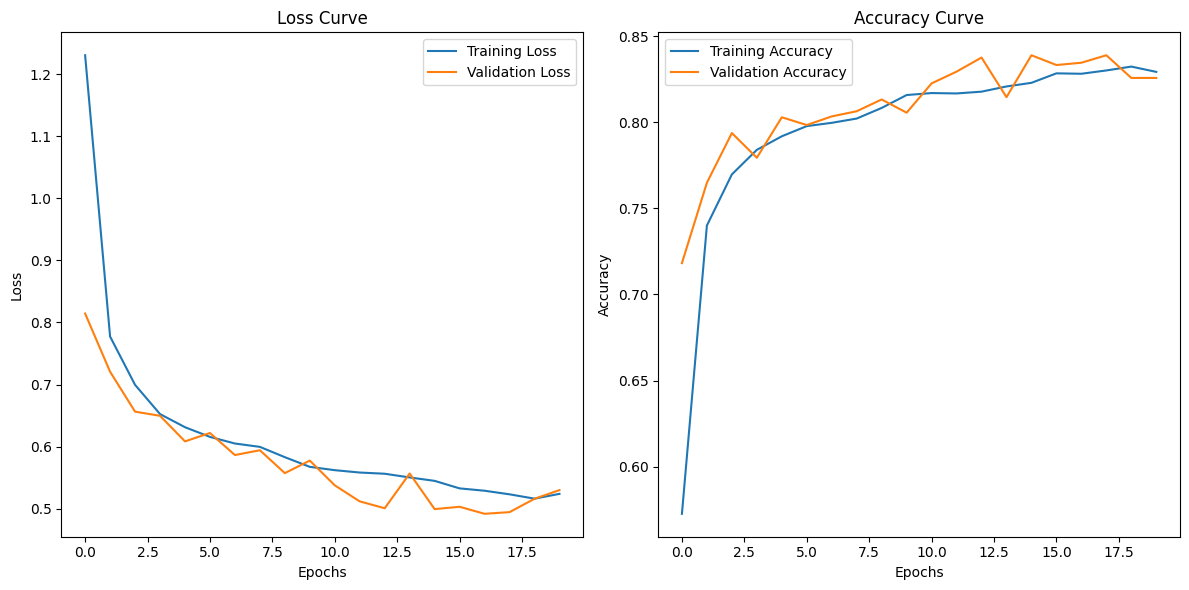

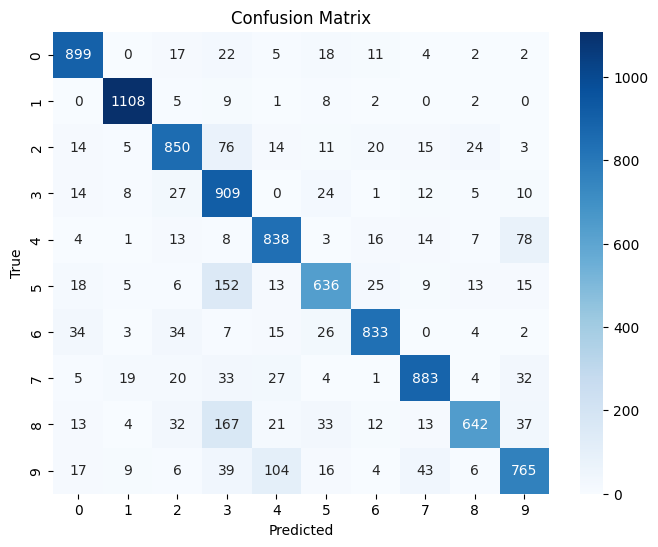

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = main(device)

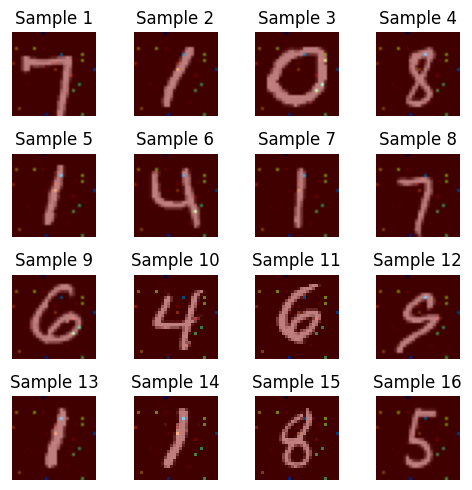

In [34]:
import cv2

def visualize_focus_with_samples(model, dataloader, input_shape, device='cuda'):
    """
    Visualizes the focus overlayed on some input samples from the dataloader.

    Parameters:
        model (SSCNet): The model to visualize.
        dataloader (DataLoader): A PyTorch dataloader with sample images.
        input_shape (tuple): The shape of the input image (height, width).
        device (str): Device to run computations on ('cuda' or 'cpu').
    """
    # Calculate the global focus map
    focus_maps = []

    x_dummy = torch.zeros(1, 1, *input_shape).to(device)
    height, width = input_shape

    for layer in model.children():
        if isinstance(layer, StochasticSamplingConv2D):
            # Extract focus distributions
            mu_x = layer.mu_x.mean(dim=0).detach().cpu().numpy()
            mu_y = layer.mu_y.mean(dim=0).detach().cpu().numpy()
            sigma_x = layer.sigma_x.mean(dim=0).detach().cpu().numpy()
            sigma_y = layer.sigma_y.mean(dim=0).detach().cpu().numpy()

            # Generate a heatmap for focus intensity
            focus_map = np.exp(-(np.power(mu_x, 2) + np.power(mu_y, 2)) / (2 * (sigma_x + sigma_y) ** 2))
            focus_map = cv2.resize(focus_map, (width, height), interpolation=cv2.INTER_LINEAR)

            focus_maps.append(focus_map)

    # Aggregate focus maps across layers
    global_focus_map = np.sum(focus_maps, axis=0)
    global_focus_map_normalized = (global_focus_map - global_focus_map.min()) / (global_focus_map.max() - global_focus_map.min())

    # Visualize focus maps overlaid on dataloader samples
    samples, _ = next(iter(dataloader))  # Get a batch of samples
    samples = samples[:16]  # Take first 4 samples for visualization
    samples = samples.numpy()

    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    axes = axes.flatten()
    for i, sample in enumerate(samples):
        sample_img = sample[0]  # Assuming grayscale image
        overlay = cv2.applyColorMap((global_focus_map_normalized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
        # Convert grayscale to RGB for blending
        sample_rgb = np.stack([sample_img] * 3, axis=-1)
        sample_rgb = (sample_rgb - sample_rgb.min()) / (sample_rgb.max() - sample_rgb.min())  # Normalize
    
        # Convert to uint8 for blending
        sample_rgb_uint8 = (sample_rgb * 255).astype(np.uint8)
        overlay_uint8 = overlay.astype(np.uint8)
    
        # Resize and blend
        overlay_uint8 = cv2.resize(overlay_uint8, (sample_rgb_uint8.shape[1], sample_rgb_uint8.shape[0]))
        blended = cv2.addWeighted(sample_rgb_uint8, 0.5, overlay_uint8, 0.5, 0)
    
        axes[i].imshow(blended)
        axes[i].axis('off')
        axes[i].set_title(f"Sample {i+1}")


    plt.tight_layout()
    plt.show()

dataloader, _, _ = load_mnist()
visualize_focus_with_samples(model, dataloader, (28, 28))